In [2]:
import sys
import os

# Get the parent directory of current directory
parent_dir = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(parent_dir)

# Now you can import from pyScripts
from oldmarch.cluster_g_logit_init_acceptpsi import *

%load_ext autoreload


In [3]:

%autoreload 2
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import

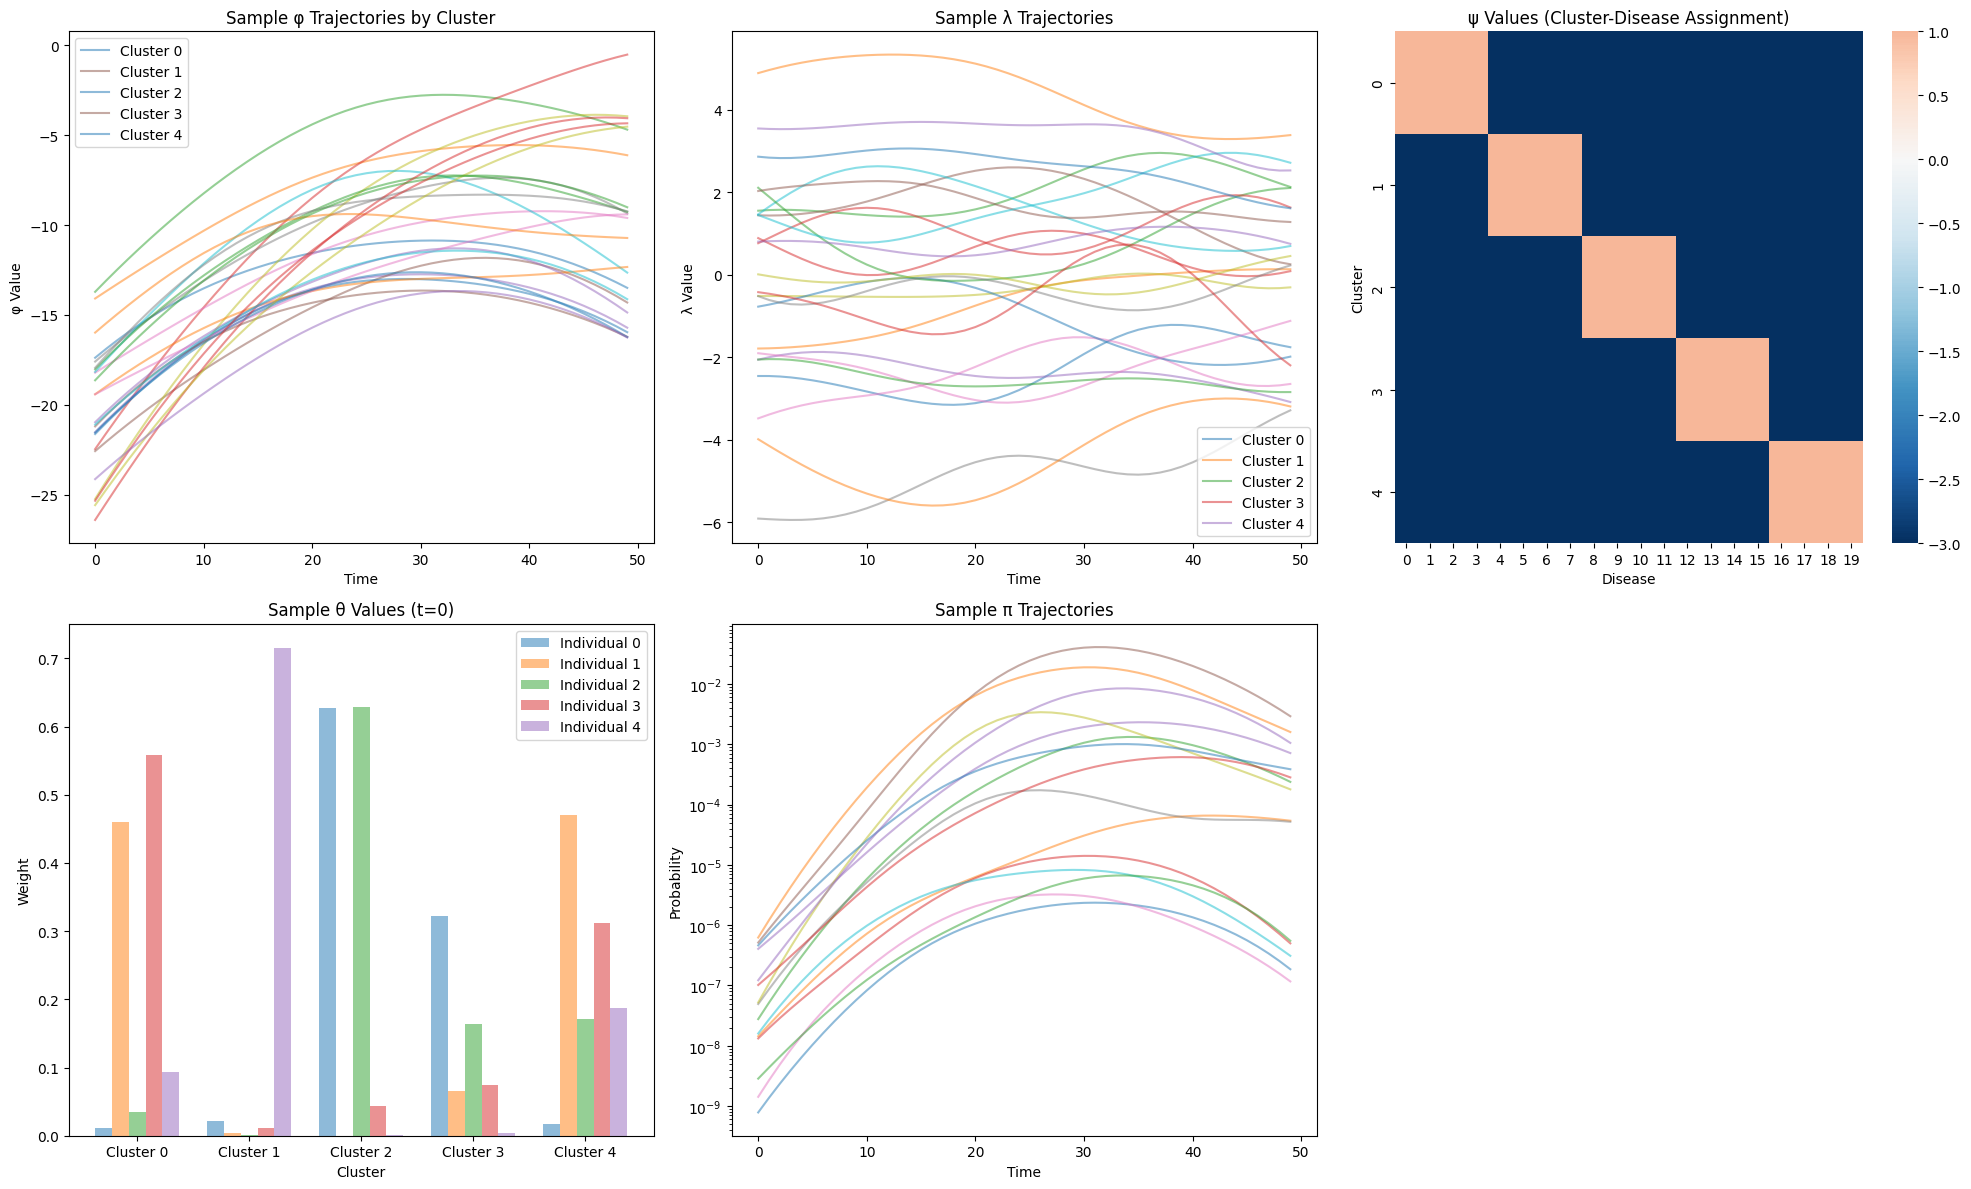

In [4]:
# Generate and plot
np.random.seed(42)
data = generate_clustered_survival_data(N=10000, D=20, T=50, K=5, P=5)
plot_synthetic_components(data)

In [5]:
# First generate synthetic data
np.random.seed(42)

# Convert data to tensors for the model
Y_tensor = torch.tensor(data['Y'], dtype=torch.float32)
G_tensor = torch.tensor(data['G'], dtype=torch.float32)
E_tensor = torch.tensor(data['event_times'], dtype=torch.float32)
true_psi = torch.tensor(data['psi'], dtype=torch.float32)


In [26]:
# Calculate prevalence
from embedding import *
prevalence_t = compute_smoothed_prevalence(Y_tensor)


Training hierarchical embedding model...
Epoch 0, Loss: 39.8740
Epoch 20, Loss: 37.3902
Epoch 40, Loss: 35.3963
Epoch 60, Loss: 33.5625
Epoch 80, Loss: 31.8277
Epoch 100, Loss: 30.1633
Epoch 120, Loss: 28.5667
Epoch 140, Loss: 27.0434
Epoch 160, Loss: 25.6104
Epoch 180, Loss: 24.2719
Epoch 200, Loss: 23.0357
Epoch 220, Loss: 21.9073
Epoch 240, Loss: 20.8875
Epoch 260, Loss: 19.9648
Epoch 280, Loss: 19.1440
Epoch 300, Loss: 18.4140
Epoch 320, Loss: 17.7688
Epoch 340, Loss: 17.1933
Epoch 360, Loss: 16.6769
Epoch 380, Loss: 16.2255
Epoch 400, Loss: 15.8318
Epoch 420, Loss: 15.4935
Epoch 440, Loss: 15.1998
Epoch 460, Loss: 14.9364
Epoch 480, Loss: 14.7036
Epoch 500, Loss: 14.4924
Epoch 520, Loss: 14.3018
Epoch 540, Loss: 14.1279
Epoch 560, Loss: 13.9677
Epoch 580, Loss: 13.8228
Epoch 600, Loss: 13.6942
Epoch 620, Loss: 13.5733
Epoch 640, Loss: 13.4611
Epoch 660, Loss: 13.3591
Epoch 680, Loss: 13.2619
Epoch 700, Loss: 13.1695
Epoch 720, Loss: 13.0818
Epoch 740, Loss: 12.9963
Epoch 760, Loss

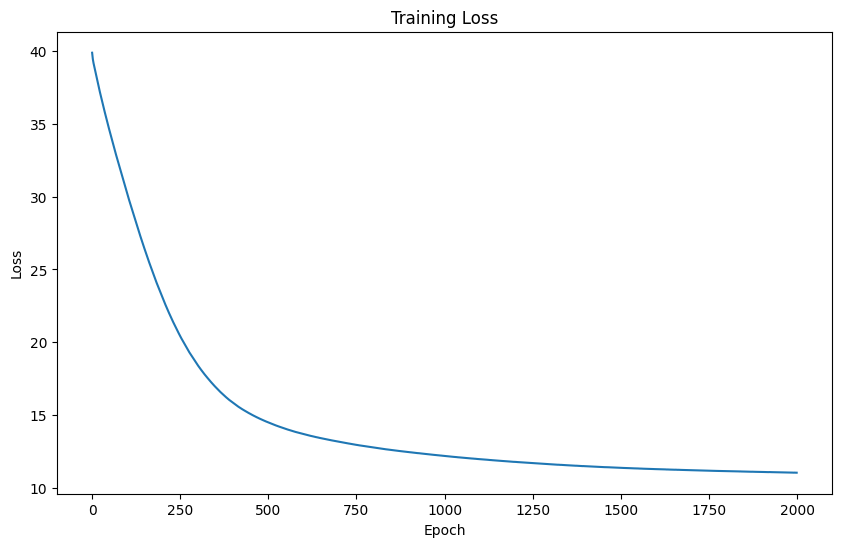

In [31]:

# Initialize the hierarchical embedding model
# Initialize the hierarchical embedding model with true psi
del model
model = HierarchicalEmbeddingModel(
    N=10000, D=20, T=50, K=5, P=5,
    G=G_tensor, Y=Y_tensor, R=0, W=0.001,
    prevalence_t=prevalence_t,
    init_sd_scaler=0.1, genetic_scale=1.0,
    embedding_dim=32,
    true_psi=torch.tensor(data['psi'], dtype=torch.float32)  # Pass true psi!
)

# Train the model
print("Training hierarchical embedding model...")
losses = model.fit(E_tensor, num_epochs=2000, learning_rate=0.5)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

IndexError: index 5 is out of bounds for axis 0 with size 5

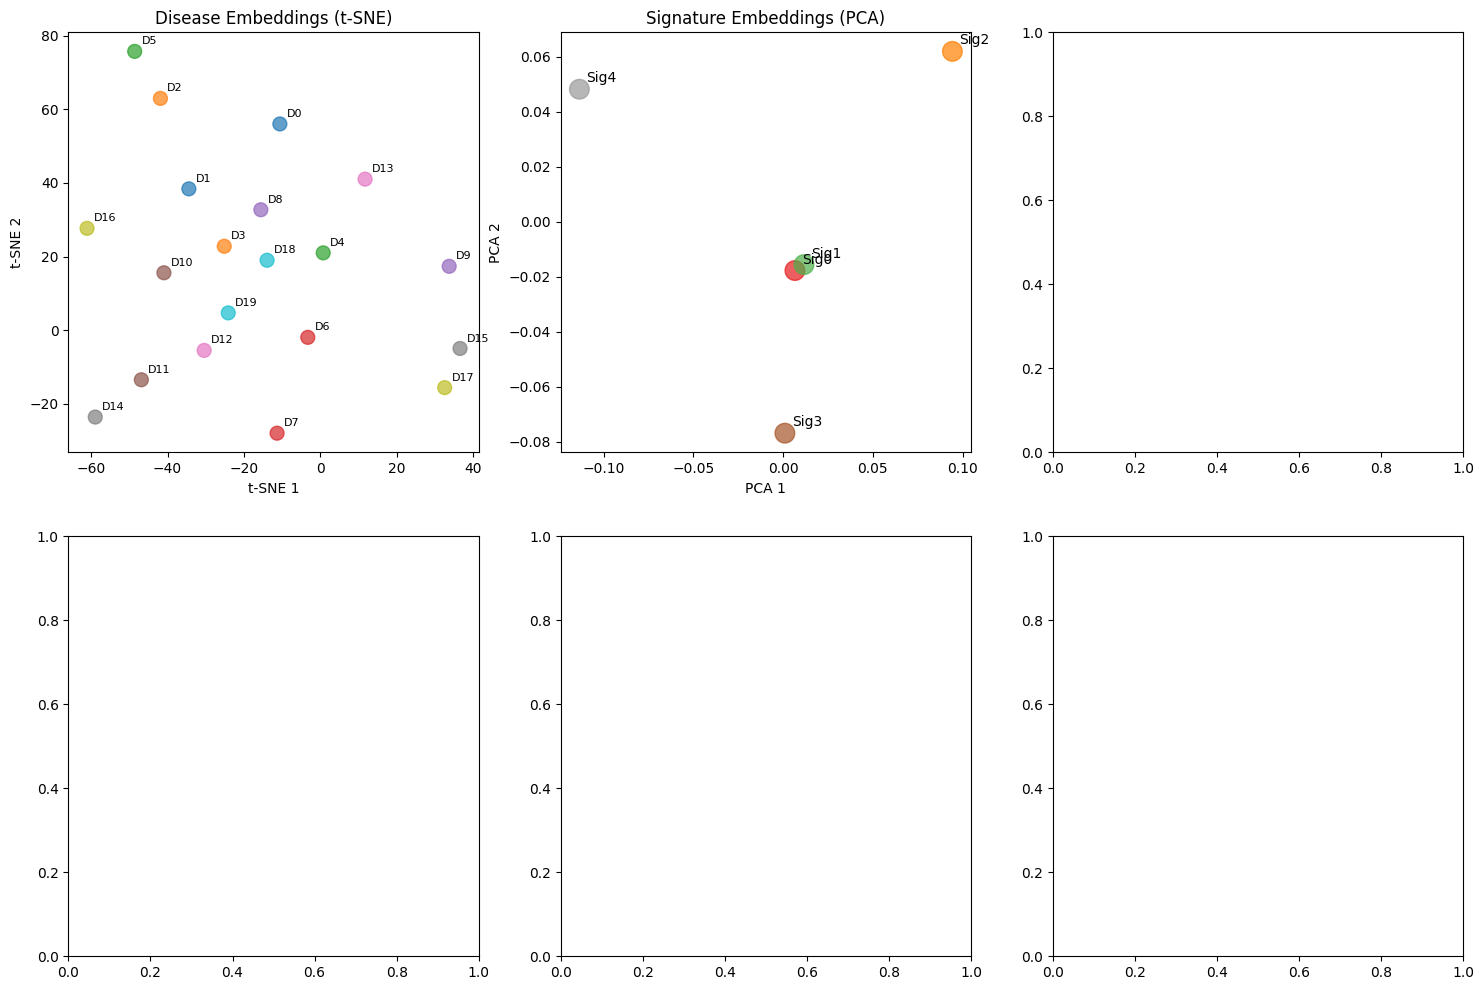

In [36]:
# Create the full visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Disease embeddings (t-SNE)
scatter = axes[0, 0].scatter(disease_2d[:, 0], disease_2d[:, 1], 
                            c=range(model.D), cmap='tab10', s=100, alpha=0.7)
axes[0, 0].set_title('Disease Embeddings (t-SNE)')
axes[0, 0].set_xlabel('t-SNE 1')
axes[0, 0].set_ylabel('t-SNE 2')

# Add disease labels
for i in range(model.D):
    axes[0, 0].annotate(f'D{i}', (disease_2d[i, 0], disease_2d[i, 1]), 
                       xytext=(5, 5), textcoords='offset points', fontsize=8)

# 2. Signature embeddings (PCA)
axes[0, 1].scatter(signature_2d[:, 0], signature_2d[:, 1], 
                  c=range(model.K_total), cmap='Set1', s=200, alpha=0.7)
axes[0, 1].set_title('Signature Embeddings (PCA)')
axes[0, 1].set_xlabel('PCA 1')
axes[0, 1].set_ylabel('PCA 2')

# Add signature labels
sig_labels = [f'Sig{i}' for i in range(model.K)] + ['Healthy']
for i, label in enumerate(sig_labels):
    axes[0, 1].annotate(label, (signature_2d[i, 0], signature_2d[i, 1]), 
                       xytext=(5, 5), textcoords='offset points', fontsize=10)

# 3. Attention weights heatmap
im = axes[0, 2].imshow(attention_weights, cmap='Blues', aspect='auto')
axes[0, 2].set_title('Attention Weights (Diseases × Signatures)')
axes[0, 2].set_xlabel('Signature')
axes[0, 2].set_ylabel('Disease')
plt.colorbar(im, ax=axes[0, 2])

# 4. Learned vs True Psi comparison
true_psi = data['psi']
axes[1, 0].scatter(true_psi.flatten(), learned_psi.flatten(), alpha=0.6)
axes[1, 0].plot([true_psi.min(), true_psi.max()], [true_psi.min(), true_psi.max()], 'r--')
axes[1, 0].set_title('Learned vs True Psi')
axes[1, 0].set_xlabel('True Psi')
axes[1, 0].set_ylabel('Learned Psi')

# 5. Attention weights for top diseases
top_diseases = np.argsort(attention_weights.max(axis=1))[-10:]
axes[1, 1].bar(range(len(top_diseases)), attention_weights[top_diseases].max(axis=1))
axes[1, 1].set_title('Max Attention Weights (Top 10 Diseases)')
axes[1, 1].set_xlabel('Disease Rank')
axes[1, 1].set_ylabel('Max Attention Weight')

# 6. Embedding norms
disease_norms = np.linalg.norm(disease_embeddings, axis=1)
signature_norms = np.linalg.norm(signature_embeddings, axis=1)

axes[1, 2].bar(range(len(disease_norms)), disease_norms, alpha=0.7, label='Diseases')
axes[1, 2].bar(range(len(signature_norms)), signature_norms, alpha=0.7, label='Signatures')
axes[1, 2].set_title('Embedding Norms')
axes[1, 2].set_xlabel('Index')
axes[1, 2].set_ylabel('L2 Norm')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

# Print some statistics
print("�� Embedding Analysis:")
print(f"   - Disease embedding norm: {disease_norms.mean():.3f} ± {disease_norms.std():.3f}")
print(f"   - Signature embedding norm: {signature_norms.mean():.3f} ± {signature_norms.std():.3f}")
print(f"   - Psi correlation: {np.corrcoef(true_psi.flatten(), learned_psi.flatten())[0, 1]:.3f}")

# Find most attended diseases for each signature
print("\n🎯 Top Diseases per Signature:")
for k in range(model.K_total):
    top_diseases = np.argsort(attention_weights[:, k])[-3:]
    sig_name = f"Signature {k}" if k < model.K else "Healthy"
    print(f"   {sig_name}: Diseases {top_diseases} (attention: {attention_weights[top_diseases, k]})")

IndexError: index 5 is out of bounds for axis 0 with size 5

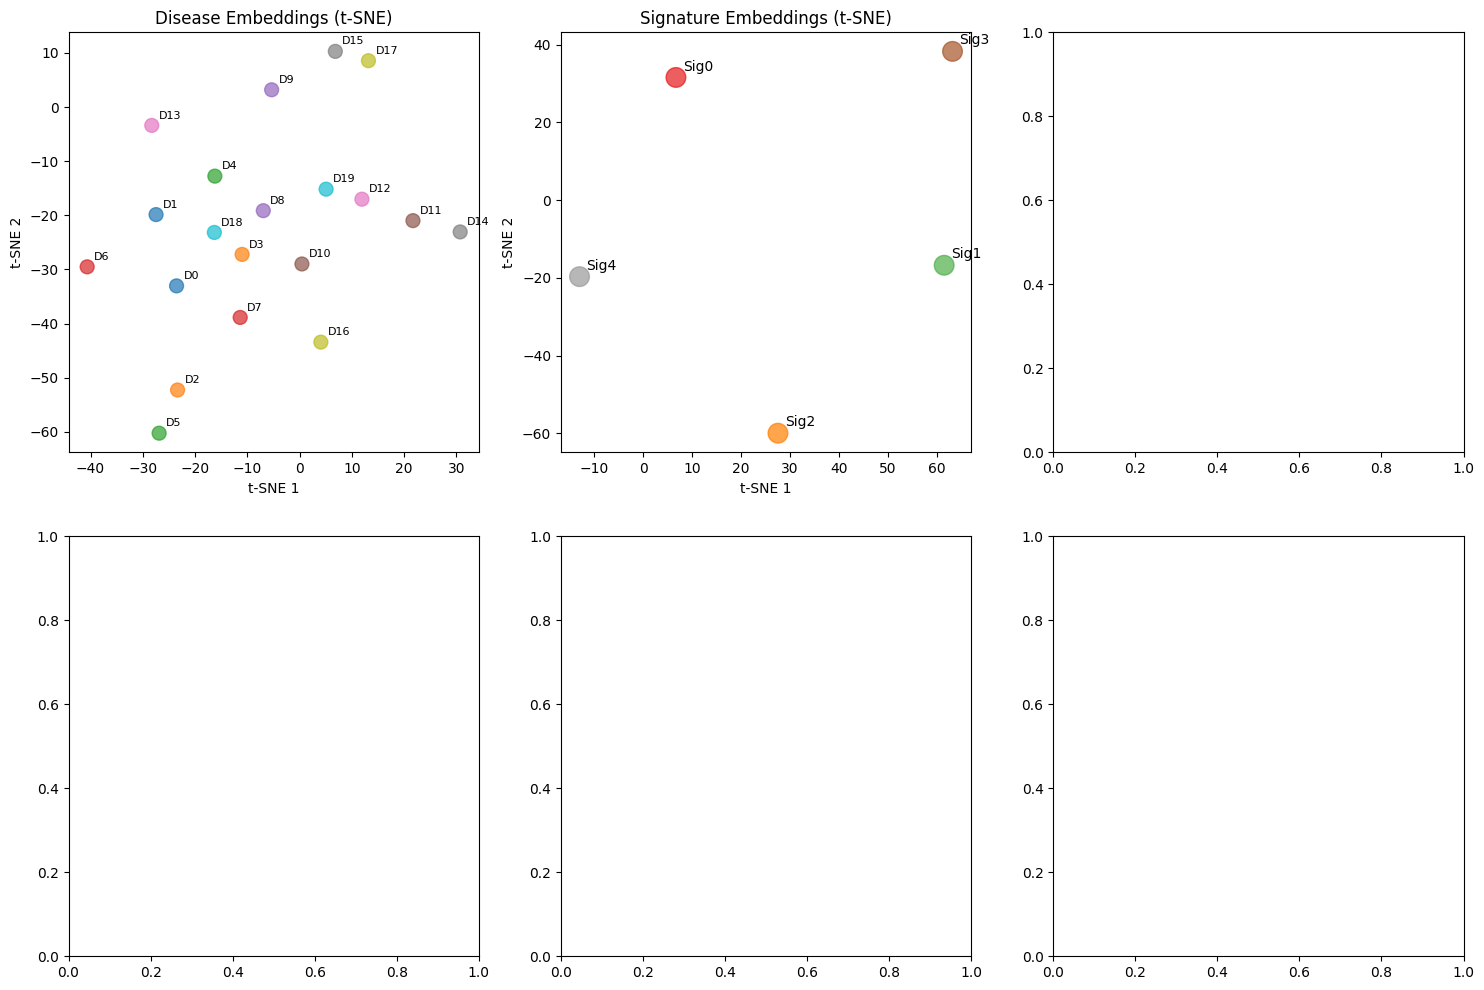

In [37]:
# Get the learned embeddings and attention weights
with torch.no_grad():
    # Get embeddings
    disease_embeddings = model.disease_embeddings.weight.numpy()
    signature_embeddings = model.signature_embeddings.weight.numpy()
    
    # Get learned psi from embeddings
    learned_psi = model.compute_psi().numpy()
    
    # Get attention weights
    E_d = model.disease_embeddings(torch.arange(model.D))
    E_k = model.signature_embeddings(torch.arange(model.K_total))
    attention_scores = torch.matmul(
        torch.matmul(E_d, model.attention_matrix),
        E_k.T
    ) / np.sqrt(model.embedding_dim)
    attention_weights = torch.softmax(attention_scores, dim=1).numpy()

# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Disease embeddings (t-SNE or PCA)
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Check if we have enough samples for t-SNE
if disease_embeddings.shape[0] >= 4:
    tsne = TSNE(n_components=2, random_state=42,perplexity=4)
    disease_2d = tsne.fit_transform(disease_embeddings)
    method_name = "t-SNE"
else:
    pca = PCA(n_components=2)
    disease_2d = pca.fit_transform(disease_embeddings)
    method_name = "PCA"

scatter = axes[0, 0].scatter(disease_2d[:, 0], disease_2d[:, 1], 
                            c=range(model.D), cmap='tab10', s=100, alpha=0.7)
axes[0, 0].set_title(f'Disease Embeddings ({method_name})')
axes[0, 0].set_xlabel(f'{method_name} 1')
axes[0, 0].set_ylabel(f'{method_name} 2')

# Add disease labels
for i in range(model.D):
    axes[0, 0].annotate(f'D{i}', (disease_2d[i, 0], disease_2d[i, 1]), 
                       xytext=(5, 5), textcoords='offset points', fontsize=8)

# 2. Signature embeddings
if signature_embeddings.shape[0] >= 4:
    signature_2d = tsne.fit_transform(signature_embeddings)
else:
    signature_2d = pca.fit_transform(signature_embeddings)

axes[0, 1].scatter(signature_2d[:, 0], signature_2d[:, 1], 
                  c=range(model.K_total), cmap='Set1', s=200, alpha=0.7)
axes[0, 1].set_title(f'Signature Embeddings ({method_name})')
axes[0, 1].set_xlabel(f'{method_name} 1')
axes[0, 1].set_ylabel(f'{method_name} 2')

# Add signature labels
sig_labels = [f'Sig{i}' for i in range(model.K)] + ['Healthy']
for i, label in enumerate(sig_labels):
    axes[0, 1].annotate(label, (signature_2d[i, 0], signature_2d[i, 1]), 
                       xytext=(5, 5), textcoords='offset points', fontsize=10)

# 3. Attention weights heatmap
im = axes[0, 2].imshow(attention_weights, cmap='Blues', aspect='auto')
axes[0, 2].set_title('Attention Weights (Diseases × Signatures)')
axes[0, 2].set_xlabel('Signature')
axes[0, 2].set_ylabel('Disease')
plt.colorbar(im, ax=axes[0, 2])

# 4. Learned vs True Psi comparison
true_psi = data['psi']
axes[1, 0].scatter(true_psi.flatten(), learned_psi.flatten(), alpha=0.6)
axes[1, 0].plot([true_psi.min(), true_psi.max()], [true_psi.min(), true_psi.max()], 'r--')
axes[1, 0].set_title('Learned vs True Psi')
axes[1, 0].set_xlabel('True Psi')
axes[1, 0].set_ylabel('Learned Psi')

# 5. Attention weights for top diseases
top_diseases = np.argsort(attention_weights.max(axis=1))[-10:]
axes[1, 1].bar(range(len(top_diseases)), attention_weights[top_diseases].max(axis=1))
axes[1, 1].set_title('Max Attention Weights (Top 10 Diseases)')
axes[1, 1].set_xlabel('Disease Rank')
axes[1, 1].set_ylabel('Max Attention Weight')

# 6. Embedding norms
disease_norms = np.linalg.norm(disease_embeddings, axis=1)
signature_norms = np.linalg.norm(signature_embeddings, axis=1)

axes[1, 2].bar(range(len(disease_norms)), disease_norms, alpha=0.7, label='Diseases')
axes[1, 2].bar(range(len(signature_norms)), signature_norms, alpha=0.7, label='Signatures')
axes[1, 2].set_title('Embedding Norms')
axes[1, 2].set_xlabel('Index')
axes[1, 2].set_ylabel('L2 Norm')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

# Print some statistics
print("�� Embedding Analysis:")
print(f"   - Disease embedding norm: {disease_norms.mean():.3f} ± {disease_norms.std():.3f}")
print(f"   - Signature embedding norm: {signature_norms.mean():.3f} ± {signature_norms.std():.3f}")
print(f"   - Psi correlation: {np.corrcoef(true_psi.flatten(), learned_psi.flatten())[0, 1]:.3f}")

# Find most attended diseases for each signature
print("\n🎯 Top Diseases per Signature:")
for k in range(model.K_total):
    top_diseases = np.argsort(attention_weights[:, k])[-3:]
    sig_name = f"Signature {k}" if k < model.K else "Healthy"
    print(f"   {sig_name}: Diseases {top_diseases} (attention: {attention_weights[top_diseases, k]})")

ValueError: perplexity must be less than n_samples

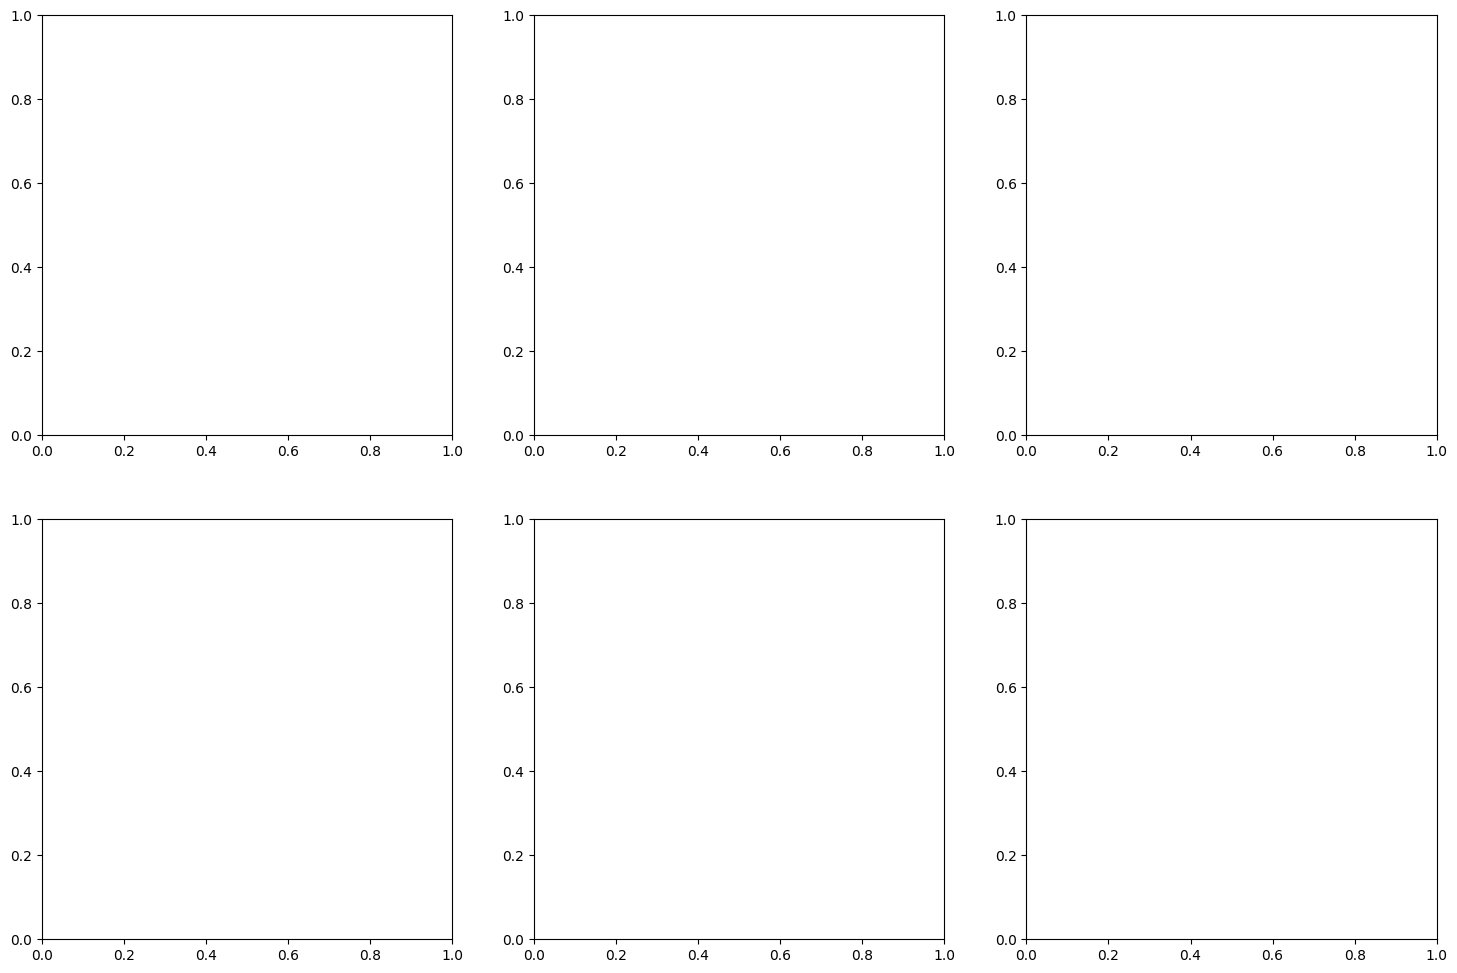

In [32]:
# Get the learned embeddings and attention weights
with torch.no_grad():
    # Get embeddings
    disease_embeddings = model.disease_embeddings.weight.numpy()
    signature_embeddings = model.signature_embeddings.weight.numpy()
    
    # Get learned psi from embeddings
    learned_psi = model.compute_psi().numpy()
    
    # Get attention weights
    E_d = model.disease_embeddings(torch.arange(model.D))
    E_k = model.signature_embeddings(torch.arange(model.K_total))
    attention_scores = torch.matmul(
        torch.matmul(E_d, model.attention_matrix),
        E_k.T
    ) / np.sqrt(model.embedding_dim)
    attention_weights = torch.softmax(attention_scores, dim=1).numpy()

# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Disease embeddings (t-SNE)
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
disease_2d = tsne.fit_transform(disease_embeddings)

scatter = axes[0, 0].scatter(disease_2d[:, 0], disease_2d[:, 1], 
                            c=range(model.D), cmap='tab10', s=100, alpha=0.7)
axes[0, 0].set_title('Disease Embeddings (t-SNE)')
axes[0, 0].set_xlabel('t-SNE 1')
axes[0, 0].set_ylabel('t-SNE 2')

# Add disease labels
for i in range(model.D):
    axes[0, 0].annotate(f'D{i}', (disease_2d[i, 0], disease_2d[i, 1]), 
                       xytext=(5, 5), textcoords='offset points', fontsize=8)

# 2. Signature embeddings
signature_2d = tsne.fit_transform(signature_embeddings)
axes[0, 1].scatter(signature_2d[:, 0], signature_2d[:, 1], 
                  c=range(model.K_total), cmap='Set1', s=200, alpha=0.7)
axes[0, 1].set_title('Signature Embeddings (t-SNE)')
axes[0, 1].set_xlabel('t-SNE 1')
axes[0, 1].set_ylabel('t-SNE 2')

# Add signature labels
sig_labels = [f'Sig{i}' for i in range(model.K)] + ['Healthy']
for i, label in enumerate(sig_labels):
    axes[0, 1].annotate(label, (signature_2d[i, 0], signature_2d[i, 1]), 
                       xytext=(5, 5), textcoords='offset points', fontsize=10)

# 3. Attention weights heatmap
im = axes[0, 2].imshow(attention_weights, cmap='Blues', aspect='auto')
axes[0, 2].set_title('Attention Weights (Diseases × Signatures)')
axes[0, 2].set_xlabel('Signature')
axes[0, 2].set_ylabel('Disease')
plt.colorbar(im, ax=axes[0, 2])

# 4. Learned vs True Psi comparison
true_psi = data['psi']
axes[1, 0].scatter(true_psi.flatten(), learned_psi.flatten(), alpha=0.6)
axes[1, 0].plot([true_psi.min(), true_psi.max()], [true_psi.min(), true_psi.max()], 'r--')
axes[1, 0].set_title('Learned vs True Psi')
axes[1, 0].set_xlabel('True Psi')
axes[1, 0].set_ylabel('Learned Psi')

# 5. Attention weights for top diseases
top_diseases = np.argsort(attention_weights.max(axis=1))[-10:]
axes[1, 1].bar(range(len(top_diseases)), attention_weights[top_diseases].max(axis=1))
axes[1, 1].set_title('Max Attention Weights (Top 10 Diseases)')
axes[1, 1].set_xlabel('Disease Rank')
axes[1, 1].set_ylabel('Max Attention Weight')

# 6. Embedding norms
disease_norms = np.linalg.norm(disease_embeddings, axis=1)
signature_norms = np.linalg.norm(signature_embeddings, axis=1)

axes[1, 2].bar(range(len(disease_norms)), disease_norms, alpha=0.7, label='Diseases')
axes[1, 2].bar(range(len(signature_norms)), signature_norms, alpha=0.7, label='Signatures')
axes[1, 2].set_title('Embedding Norms')
axes[1, 2].set_xlabel('Index')
axes[1, 2].set_ylabel('L2 Norm')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

# Print some statistics
print("�� Embedding Analysis:")
print(f"   - Disease embedding norm: {disease_norms.mean():.3f} ± {disease_norms.std():.3f}")
print(f"   - Signature embedding norm: {signature_norms.mean():.3f} ± {signature_norms.std():.3f}")
print(f"   - Psi correlation: {np.corrcoef(true_psi.flatten(), learned_psi.flatten())[0, 1]:.3f}")

# Find most attended diseases for each signature
print("\n🎯 Top Diseases per Signature:")
for k in range(model.K_total):
    top_diseases = np.argsort(attention_weights[:, k])[-3:]
    sig_name = f"Signature {k}" if k < model.K else "Healthy"
    print(f"   {sig_name}: Diseases {top_diseases} (attention: {attention_weights[top_diseases, k]})")

In [ ]:
model_est = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=data['Y'].shape[0], 
    D=data['Y'].shape[1], 
    T=data['Y'].shape[2], 
    K=data['phi'].shape[0],  # number of clusters
    P=data['G'].shape[1],    # number of genetic features
    G=G_tensor,
    Y=Y_tensor,
    R=0,                     # Make sure R is provided
    W=0,                     # Disable GP prior for speed
    prevalence_t=prevalence_t,
    init_sd_scaler=1e-1,     # This matches your class definition
    genetic_scale=1,
    signature_references=None,
    healthy_reference=None,
    disease_names=None,
    flat_lambda=True,
    learn_kappa=True
)

model_est.visualize_initialization()


In [ ]:
from analyze_clusters import *
plot_confusion_matrix(data['clusters'], model_est.clusters, K=5) 

In [ ]:
from clust_huge_amp import *

In [ ]:
model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=data['Y'].shape[0], 
    D=data['Y'].shape[1], 
    T=data['Y'].shape[2], 
    K=data['phi'].shape[0],  # number of clusters
    P=data['G'].shape[1],    # number of genetic features
    G=G_tensor,
    Y=Y_tensor,
    R=0,                     # Make sure R is provided
    W=0,                     # Disable GP prior for speed
    prevalence_t=prevalence_t,
    init_sd_scaler=1e-1,     # This matches your class definition
    genetic_scale=1,
    signature_references=None,
    healthy_reference=None,
    disease_names=None,
    flat_lambda=True,
    learn_kappa=True
)

model.visualize_initialization()


In [ ]:

# Initialize with true psi
model.initialize_params(true_psi=true_psi)
model.clusters = data['clusters'] 

model.visualize_initialization()

In [ ]:

K=5
# Store initial psi values
initial_psi = model.psi.detach().clone()

import cProfile
import pstats
from pstats import SortKey

# For the healthtoo version
profiler = cProfile.Profile()
profiler.enable()
history_new = model.fit(E_tensor, num_epochs=100, learning_rate=1e-1, lambda_reg=1e-2)
profiler.disable()
stats = pstats.Stats(profiler).sort_stats(SortKey.CUMULATIVE)
stats.print_stats(20)

In [ ]:
history_new[0]
    

In [ ]:
model.kappa

In [ ]:
def plot_training_evolution(history_tuple):
    losses, gradient_history = history_tuple
    
    plt.figure(figsize=(15, 5))
    
    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(losses, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Evolution')
    #plt.yscale('log')
    plt.legend()
    
    # Plot lambda gradients
    plt.subplot(1, 3, 2)
    lambda_norms = [torch.norm(g).item() for g in gradient_history['lambda_grad']]
    plt.plot(lambda_norms, label='Lambda gradients')
    #plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Gradient norm')
    plt.title('Lambda Gradient Evolution')
    plt.legend()
    
    # Plot phi gradients
    plt.subplot(1, 3, 3)
    phi_norms = [torch.norm(g).item() for g in gradient_history['phi_grad']]
    plt.plot(phi_norms, label='Phi gradients')
    #plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Gradient norm')
    plt.title('Phi Gradient Evolution')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [ ]:
plot_training_evolution(history_new)

In [ ]:
lambda_nans = [torch.isnan(g).any().item() for g in history_new[1]['lambda_grad']]
phi_nans = [torch.isnan(g).any().item() for g in history_new[1]['phi_grad']]

In [ ]:
initial_psi


In [ ]:
model.psi

In [ ]:
model.kappa

In [ ]:
# For plotting smoothed prevalences
def plot_smoothed_prevalences(model, data):
    # Data smoothed prevalence
    data_prev = data['Y'].mean(axis=0)  # Average across individuals
    
    # Model smoothed prevalence (using mu_d/logit_prev_t)
    model_prev = torch.sigmoid(model.logit_prev_t)  # Convert logits to probabilities
    
    plt.figure(figsize=(10, 6))
    
    # Plot for each disease
    for d in range(data_prev.shape[0]):
        plt.plot(data_prev[d], 'b-', alpha=0.3, label='Data' if d==0 else '')
        plt.plot(model_prev[:, d].detach().numpy(), 'r--', alpha=0.3, 
                label='Model' if d==0 else '')
    
    plt.xlabel('Time')
    plt.ylabel('Prevalence')
    plt.title('Smoothed Prevalences: Data vs Model')
    plt.legend()
    plt.yscale('log')  # Optional: use log scale if prevalences vary widely
    plt.grid(True)
    plt.show()

In [ ]:
with torch.no_grad():
    pi_pred, theta, phi = model.forward()
    pi_pred = pi_pred.cpu().numpy()

In [ ]:
model.visualize_initialization()

In [ ]:
# For plotting smoothed prevalences
def plot_smoothed_prevalences(model, data):
    # Data smoothed prevalence
    data_prev = compute_smoothed_prevalence(data['Y'])  # Average across individuals
    
    # Model smoothed prevalence (using mu_d/logit_prev_t)
    model_prev = torch.sigmoid(model.logit_prev_t)  # Convert logits to probabilities
    
    plt.figure(figsize=(10, 6))
    
    # Plot for each disease
    for d in range(data_prev.shape[0]):
        plt.plot(data_prev[d], 'b-', alpha=0.3, label='Data' if d==0 else '')
        plt.plot(model_prev[d, :].detach().numpy(), 'r--', alpha=0.3, 
                label='Model' if d==0 else '')
    
    plt.xlabel('Time')
    plt.ylabel('Prevalence')
    plt.title('Smoothed Prevalences: Data vs Model')
    plt.legend()
    plt.yscale('log')  # Optional: use log scale if prevalences vary widely
    plt.grid(True)
    plt.show()

plot_smoothed_prevalences(model, data)

In [ ]:
# Mean predicted probability for disease 3 over time
mean_pred_d3 = pi_pred[:, 3, :].mean(axis=0)  # Average across people

# Actual prevalence for disease 3 over time
real_prev_pi = data['pi'][:, 3, :].mean(axis=0)  # Average across people

#real_prev_d3 = data['Y'][:, 3, :].mean(axis=0)  # Average across people

real_prev_d3 = model.prevalence_t[3,:]  # Average across people

# Plot comparison
plt.figure(figsize=(10,6))
plt.plot(mean_pred_d3, label='Model Predicted average pi for disease 3')
plt.plot(real_prev_pi, label='Actual Average Pi for disease 3 ')
plt.plot(real_prev_d3, label='Actual Incidence for disease 3')
plt.title('Disease 3: Predicted vs Actual Prevalence')
plt.legend()
plt.show()

In [ ]:
# Mean predicted probability for disease 3 over time
mean_pred_d3 = pi_pred[1, 3, :]  # Average across people

# Actual prevalence for disease 3 over time
real_prev_pi = data['pi'][1,3, :]  # Average across people

#real_prev_d3 = data['Y'][:, 3, :].mean(axis=0)  # Average across people

#real_prev_d3 = model.prevalence_t[3,:]  # Average across people

# Plot comparison
plt.figure(figsize=(10,6))
plt.plot(mean_pred_d3, label='Model Predicted person 1 pi for disease 3')
plt.plot(real_prev_pi, label='Actual person 1  for disease 3 ')
#plt.plot(real_prev_d3, label='Actual Incidence for disease 3')
plt.title('Disease 3: Predicted vs Actual Prevalence')
plt.legend()
plt.show()

In [ ]:
# Average over all diseases and all individuals
mean_pred_all = pi_pred.mean(axis=(0,1))  # Average across people and diseases
real_incidence_all = model.prevalence_t.mean(axis=0)  # Average across diseases
real_pi_all = data['pi'].mean(axis=(0,1)) # Average across diseases

plt.figure(figsize=(10,6))
plt.plot(mean_pred_all, 'b-', label='Model Predicted')
plt.plot(real_incidence_all, 'r-', label='Actual Prevalence') 
plt.plot(real_pi_all, 'g-', label='Simulated pi') 


plt.title('Average Disease Prevalence: Predicted vs Actual')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [ ]:
model.kappa

In [ ]:
# 1. Get predictions and actual values
predicted = model.forward()
pi_pred = predicted[0] if isinstance(predicted, tuple) else predicted
pi_pred = pi_pred.cpu().detach().numpy()
Y = model.Y.cpu().detach().numpy()

# 2. Calculate marginal risks directly
# Assuming dimensions are: [N, D, T] for both Y and pi_pred
observed_risk = Y.mean(axis=0).flatten()  # average across individuals
predicted_risk = pi_pred.mean(axis=0).flatten()
#observed_risk=mu_dt_flat
# 3. Apply calibration
scale_factor = np.mean(observed_risk) / np.mean(predicted_risk)
calibrated_risk = predicted_risk * scale_factor
print(scale_factor)
print(np.mean(observed_risk))
print(np.mean(predicted_risk)) 
print(np.mean(calibrated_risk))

In [ ]:
calibrated_risk.shape

In [ ]:
scale_factor

In [ ]:
# Average over all diseases and all individuals
mean_pred_all = pi_pred.mean(axis=(0,1))
#mean_pred_all = pi_pred.mean(axis=(0,1))  # Average across people and diseases
real_incidence_all = model.prevalence_t.mean(axis=0)  # Average across diseases
#real_pi_all = calibrated_risk.mean(axis=(0,1)) # Average across diseases

plt.figure(figsize=(10,6))
plt.plot(mean_pred_all, 'b-', label='Model Predicted')
plt.plot(real_incidence_all, 'r-', label='Actual Prevalence') 
plt.plot(real_pi_all, 'g-', label='Simulated pi') 


plt.title('Average Disease Prevalence: Predicted vs Actual')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [ ]:

# 4. Plot
plt.figure(figsize=(12, 5))

# Original predictions
plt.subplot(121)
plt.scatter(observed_risk, predicted_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Original Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Predicted Risk')

# Calibrated predictions
plt.subplot(122)
plt.scatter(observed_risk, calibrated_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Calibrated Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Calibrated Risk')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Mean observed risk: {np.mean(observed_risk):.6f}")
print(f"Mean predicted risk (original): {np.mean(predicted_risk):.6f}")
print(f"Mean predicted risk (calibrated): {np.mean(calibrated_risk):.6f}")
print(f"Calibration scale factor: {scale_factor:.3f}")


In [ ]:
def plot_hazard_comparison(Y, pi_pred, true_pi, calibration_factor):
    N, D, T = Y.shape
    
    # Create at_risk mask
    at_risk = np.ones_like(Y, dtype=bool)
    for n in range(N):
        for d in range(D):
            event_times = np.where(Y[n,d,:])[0]
            if len(event_times) > 0:
                at_risk[n,d,(event_times[0]+1):] = False
    
    # Apply calibration to predictions
    calibrated_pred = pi_pred * calibration_factor
    
    # Calculate means for at-risk only
    mean_pred = []
    mean_true = []
    mean_obs = []
    for t in range(T):
        mask_t = at_risk[:,:,t]
        if mask_t.sum() > 0:
            mean_pred.append(calibrated_pred[:,:,t][mask_t].mean())
            mean_true.append(true_pi[:,:,t][mask_t].mean())
            mean_obs.append(Y[:,:,t][mask_t].mean())
    
    plt.figure(figsize=(12,8))
    plt.plot(mean_pred, 'b-', label='Calibrated Model Prediction')
    plt.plot(mean_true, 'g--', label='True Hazard')
    plt.plot(mean_obs, 'r.', label='Observed Events')
    plt.title('Hazard Rates (At-Risk Individuals)')
    plt.xlabel('Time')
    plt.ylabel('Hazard')
    plt.legend()
    plt.show()

In [ ]:
def calculate_calibration_factor(Y, pi_pred, true_pi):
    """
    Calculate calibration factor comparing predictions to true hazards
    Only using at-risk times
    """
    # Create at_risk mask
    N, D, T = Y.shape
    at_risk = np.ones_like(Y, dtype=bool)
    for n in range(N):
        for d in range(D):
            event_times = np.where(Y[n,d,:])[0]
            if len(event_times) > 0:
                at_risk[n,d,(event_times[0]+1):] = False
    
    # Get valid predictions and true values
    valid_pred = pi_pred[at_risk]
    valid_true = true_pi[at_risk]
    
    # Calculate calibration factor
    calibration_factor = valid_true.mean() / valid_pred.mean()
    
    print(f"Mean predicted: {valid_pred.mean():.6f}")
    print(f"Mean true: {valid_true.mean():.6f}")
    print(f"Calibration factor: {calibration_factor:.4f}")
    
    return calibration_factor

In [ ]:
calculate_calibration_factor(Y, pi_pred, data['pi'])

In [ ]:
plot_hazard_comparison(data['Y'], pi_pred, data['pi'],1)

In [ ]:
def calculate_fair_calibration_factor(Y, pi_pred):
    N, D, T = Y.shape
    
    # Create at_risk mask
    at_risk = np.ones_like(Y, dtype=bool)
    for n in range(N):
        for d in range(D):
            event_times = np.where(Y[n,d,:])[0]
            if len(event_times) > 0:
                at_risk[n,d,(event_times[0]+1):] = False
    
    # Calculate ratio of observed events to predictions for at-risk individuals
    total_observed = 0
    total_predicted = 0
    
    for t in range(T):
        mask_t = at_risk[:,:,t]
        if mask_t.sum() > 0:
            total_observed += Y[:,:,t][mask_t].sum()
            total_predicted += pi_pred[:,:,t][mask_t].sum()
    
    return total_observed / total_predicted if total_predicted > 0 else 1.0

cf=calculate_fair_calibration_factor(Y, pi_pred)

In [ ]:
cf

In [ ]:
# Calibration plot
from clust_huge_amp_w_warp import plot_calibration_at_risk
plot_calibration_at_risk(pi_pred, data['Y'],use_log_scale=True)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_true_calibration(pi_pred, true_pi, Y, n_bins=20, use_log_scale=False, min_bin_count=50):
    """
    Plots calibration curve: predicted pi vs. true pi (ground truth), at at-risk times.
    """
    # Ensure numpy arrays
    if hasattr(pi_pred, 'detach'):
        pi_pred = pi_pred.detach().cpu().numpy()
    if hasattr(true_pi, 'detach'):
        true_pi = true_pi.detach().cpu().numpy()
    if hasattr(Y, 'detach'):
        Y = Y.detach().cpu().numpy()
    N, D, T = Y.shape

    # At-risk mask
    at_risk = np.ones_like(Y, dtype=bool)
    for n in range(N):
        for d in range(D):
            event_times = np.where(Y[n, d, :])[0]
            if len(event_times) > 0:
                at_risk[n, d, (event_times[0]+1):] = False

    pred = pi_pred[at_risk]
    truth = true_pi[at_risk]

    # Bin by predicted probability
    if use_log_scale:
        bin_edges = np.logspace(np.log10(max(1e-7, pred.min())), np.log10(pred.max()), n_bins + 1)
    else:
        bin_edges = np.linspace(pred.min(), pred.max(), n_bins + 1)

    bin_means = []
    truth_means = []
    counts = []

    for i in range(n_bins):
        mask = (pred >= bin_edges[i]) & (pred < bin_edges[i + 1])
        if np.sum(mask) >= min_bin_count:
            bin_means.append(np.mean(pred[mask]))
            truth_means.append(np.mean(truth[mask]))
            counts.append(np.sum(mask))

    # Plot
    plt.figure(figsize=(7, 7))
    if use_log_scale:
        plt.xscale('log')
        plt.yscale('log')
        plt.plot([1e-7, 1], [1e-7, 1], '--', color='gray', label='Perfect calibration')
    else:
        plt.plot([0, 1], [0, 1], '--', color='gray', label='Perfect calibration')

    plt.plot(bin_means, truth_means, 'o-', label='True risk')
    plt.xlabel('Predicted Event Rate')
    plt.ylabel('True Event Rate')
    plt.title('Calibration to Ground Truth (At-Risk Only)')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', alpha=0.3)
    plt.show()

    # Print summary stats
    mse = np.mean((np.array(bin_means) - np.array(truth_means))**2)
    print(f'MSE: {mse:.2e}')
    print(f'Mean Predicted: {np.mean(pred):.2e}')
    print(f'Mean True: {np.mean(truth):.2e}')
    print(f'N total: {len(pred):,}')

    return bin_means, truth_means, counts

# Example usage:
plot_true_calibration(pi_pred, data['pi'], data['Y'], n_bins=20, use_log_scale=True)